# Basic conditional workflow with langGraph


In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

load_dotenv()  # Load environment

True

In [27]:
class ModelSentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"]


class ModelSentimentAnalysisSchema(BaseModel):
    issue_type: Literal["ux", "bug", "other"]
    user_tone: Literal["rude", "polite", "neutral"]
    urgency: Literal["urgent", "normal", "low"] = Field(
        description="Urgency of the issue to be fixed"
    )


model = ChatOpenAI(model="gpt-5-nano")
sentimental_model = model.with_structured_output(ModelSentimentSchema, strict=True)

sentiment_analyzer_model = model.with_structured_output(ModelSentimentAnalysisSchema, strict=True)


In [28]:
# define base schema

class SentimentWorkflowSchema(TypedDict):
    user_review: str
    sentiment_classification: str
    sentiment_analysis: dict
    system_response: str

In [40]:
def classify_sentiment(state: SentimentWorkflowSchema):
    user_review = state["user_review"]
    prompt = f"""
    Based on following user review classify the sentiment as positive, negative or neutral \n
    {user_review}
    """
    sentiment = sentimental_model.invoke(prompt)
    return {"sentiment_classification": sentiment.sentiment}


def analyse_sentiment(state: SentimentWorkflowSchema):
    """Analyze review if negative sentiment"""
    prompt = f"""
        Analyse the user's review as its sentiment is {state["sentiment_classification"]}. \n
        Return -
            - issue_type which can be "ux", "bug", "other"
            - user_tone which can be "rude", "polite", "neutral"
            - urgency which can be "urgent", "normal", "low"

    """
    analysis = sentiment_analyzer_model.invoke(prompt)
    return {"sentiment_analysis": analysis.model_dump_json()}


def construct_positive_system_response(state: SentimentWorkflowSchema):
    prompt = f"""
        Based on user's postive feedback , construct a simple and polite thankful response for his review. \n
        Suggest him to leave a review on website. \n
        User review - {state["user_review"]}
    """
    result = model.invoke(prompt)
    return {"system_response": result.content}


def conditional_positive_negative_sentiment(
    state: SentimentWorkflowSchema,
) -> Literal["analyse_sentiment", "construct_positive_system_response"]:
    if state["sentiment_classification"] == "positive":
        return "construct_positive_system_response"
    return "analyse_sentiment"


def construct_negative_system_response(state: SentimentWorkflowSchema):
    prompt = f"""
        Based on user's negative feedback , construct a simple and polite response for his review. \n
        Do not add additional support details \n
        User review - {state["user_review"]}
        Review details - {state["sentiment_analysis"]}
    """
    result = model.invoke(prompt)
    return {"system_response": result.content}

In [41]:
graph = StateGraph(SentimentWorkflowSchema)

graph.add_node("classify_sentiment", classify_sentiment)
graph.add_node("construct_positive_system_response", construct_positive_system_response)
graph.add_node("analyse_sentiment", analyse_sentiment)
graph.add_node("construct_negative_system_response", construct_negative_system_response)


graph.add_edge(START, "classify_sentiment")
graph.add_conditional_edges("classify_sentiment", conditional_positive_negative_sentiment)
graph.add_edge("analyse_sentiment", "construct_negative_system_response")
graph.add_edge("construct_negative_system_response", END)
graph.add_edge("construct_positive_system_response", END)

workflow = graph.compile()

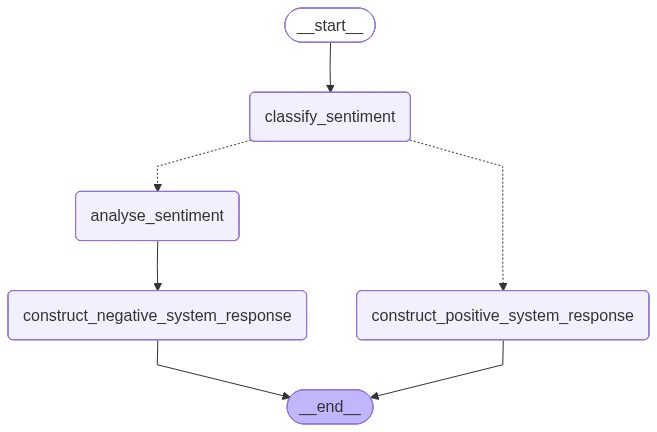

In [19]:
workflow

In [31]:
initial_state = {
    "user_review": "The product is really easy to use and ux is very friendly"
}

final_state = workflow.invoke(initial_state)
print(final_state)

{'user_review': 'The product is really easy to use and ux is very friendly', 'sentiment_classification': 'positive', 'system_response': 'Thank you for your kind feedback! We’re delighted to hear that the product is easy to use and the UX is friendly. Your review helps others make decisions. If you have a moment, please consider leaving a quick review on our website. Thanks again for your support!'}


In [42]:
initial_state = {
    "user_review": "The product sucks, having a hard time to use it. Stuck on authentication window for hours"
}

final_state = workflow.invoke(initial_state)
print(final_state)

{'user_review': 'The product sucks, having a hard time to use it. Stuck on authentication window for hours', 'sentiment_classification': 'negative', 'sentiment_analysis': '{"issue_type":"ux","user_tone":"neutral","urgency":"normal"}', 'system_response': 'Sorry to hear you’re having a hard time and getting stuck on the authentication window. We appreciate your feedback and are looking into this to improve the experience. Thank you for letting us know.'}
